In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from neuron import NeuronParam, SimpleNeuron
from synapse import Synapse
from encoding import RF_convolution, encode, RF_kernel
from parameter import TrainParam
from STDP import stdp

In [2]:
np.random.seed(1)
fixed_weight = np.random.uniform(0,1.,(256,3))

In [3]:
T = 150
dt = 1
t_pre = -20
t_post = 20


n1 = 16*16 # of neurons in layer 1
n2 = 3 # of neurons in layer 2

wmin=-1.2
wmax=2.
tau_pre = 10
tau_post = 10
A_pre = 0.3
A_post = 0.8

lr = 0.02

train_param = TrainParam(T = T,
                         dt = dt)
    
neuron_param = NeuronParam(t_refractory = 30,
                           V_rest = 0,
                           V_thr = 10,
                           V_min = -5,
                           leak = 0.75, 
                           record = True)

learning_rule = lambda x : stdp(x,
                                tau_pre = tau_pre, 
                                tau_post = tau_post, 
                                A_pre = A_pre, 
                                A_post = A_post)



In [4]:
timeline = np.arange(0,T+dt,dt)

layer = [SimpleNeuron(neuron_param) for _ in range(n2)]

synapse = Synapse(n1,layer)

synapse.random_initialize(0,wmax*0.5)

In [5]:
synapse.weight = fixed_weight

In [14]:
np.zeros(4)

array([0., 0., 0., 0.])

In [17]:
for i in np.nonzero(np.array([1,2,0,0]))[0]:
    print(i)

0
1


In [6]:
learn = True
inhibit = True
n_epoch = 3

epoch_output = []
n_winner = np.zeros((3,n2))
for epoch in tqdm(range(n_epoch)):
    outputs = [] 
    for num in range(3):
        img_win = -1
        f_spike = 0


        image = cv2.imread(f"data2/{num}.png",0)
        image = RF_convolution(image,RF_kernel)
        input_spiketrain = encode(image,train_param)
        #adaptation = 300./np.max(np.sum(input_spiketrain,axis=0)) * 0.01
        adaptation = 1
        #var_thr_list = [13.333333,10.0,13.6666666]
        #for neuron in layer:
        #    neuron.V_thr = var_thr_list[num]
        #print(adaptation)
        

        synapse.reset()


        output_spiketrain = []
        for i,t in enumerate(timeline):
            input_spikes = input_spiketrain[:,i] # size = (n1, )
            output_spikes = synapse.run(input_spikes,
                                        t,
                                        adaptation,
                                        lateral_inhibition = f_spike) # size = (n2,)
            output_spiketrain.append(output_spikes)

            if learn:
                for j,s in enumerate(output_spikes):
                    if(s==1): #SPIKE
                        for delta_t in range(-dt-dt,t_pre-dt, -dt): #delta_t < 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for k in range(n1):
                                    if input_spiketrain[k,i+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[k,j]
                                        assert dw>0
                                        synapse.weight[k,j] += dw*(wmax-w)*lr*adaptation
                        for delta_t in range(dt+dt,t_post+dt,dt): #delta_t > 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for k in range(n1):
                                    if input_spiketrain[k,i+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[k,j]
                                        assert dw<0
                                        synapse.weight[k,j] += dw*(w-abs(wmin))*lr*adaptation
            
            
            if(img_win!=100):
                for p in range(par.m):
                    if sum(train[p])==0:
                        synapse[img_win][p] -= 0.06*par.scale
                        if(synapse[img_win][p]<par.w_min):
                            synapse[img_win][p] = par.w_min
            
                


        outputs.append(np.array(output_spiketrain).T)
    epoch_output.append(outputs)

 67%|██████▋   | 2/3 [00:00<00:00, 10.59it/s]

0
1
2
0
1
0
2
1
2
1
2
1
0
2
1
1
2
1
2
1
2
1
2
1
2
1
0
2
0
1
0
2
1
2
1
2
1
0
2
1
1
2
1
2
1
2
1
2
1
2
1
0
2
0
1
0


100%|██████████| 3/3 [00:00<00:00, 10.37it/s]

2
1
2
1
2
1
0
2
1
1
2
1
2
1
2
1
2
1
2


In [7]:
import numpy as np

In [8]:
np.argmax(np.array([1,2,3]))

2

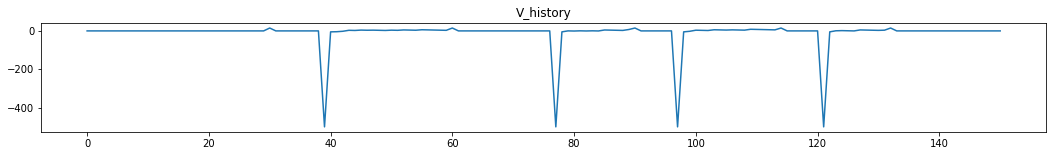

In [9]:
plt.figure(figsize=(18,2))
plt.plot(layer[1].V_history)
plt.title("V_history")
plt.show()

In [10]:
n_winner

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

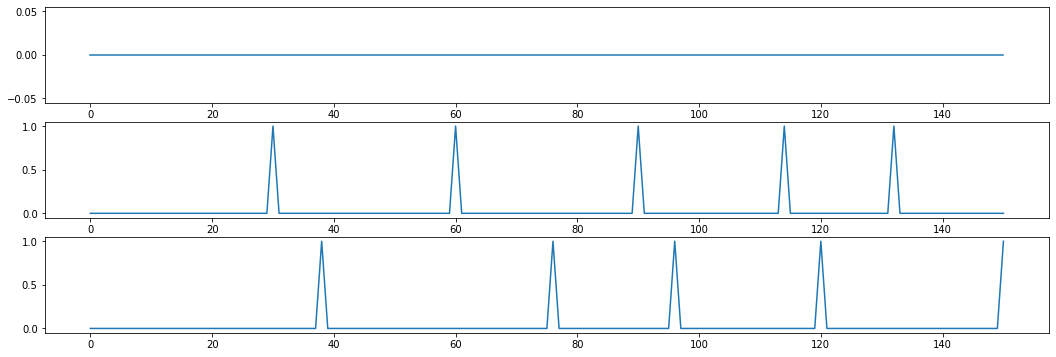

In [11]:
epoch = 2
idx = 2
fig = plt.figure(figsize=(18,2*n2))
axes=[]
for i in range(n2):
    axes.append(fig.add_subplot(n2,1,i+1))
    axes[i].plot(epoch_output[epoch][idx][i,:])

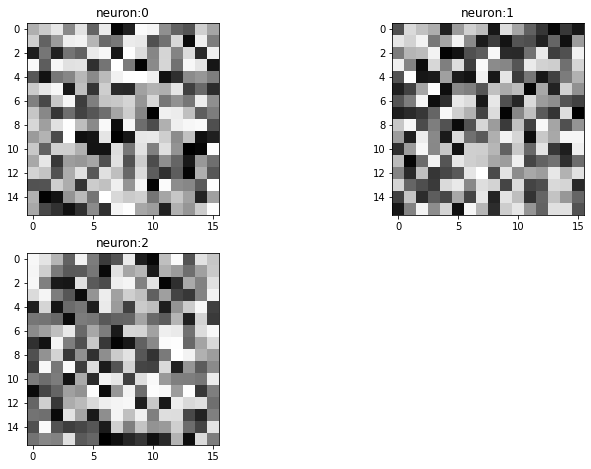

1.0332550574018642 0.017584896612062778


In [12]:
fig = plt.figure(figsize=(12,12))
axes = []
row = 3
col = n2//row + 1
max_ = np.max(synapse.weight)
min_ = np.min(synapse.weight)
for num in range(n2):
    learned_img = np.interp(synapse.weight[:,num].reshape(16,16),[min_,max_],[0,255])
    axes.append(fig.add_subplot(row,col,num+1))
    axes[num].imshow(learned_img,cmap='Greys')
    axes[num].set_title(f"neuron:{num}")

plt.show()

print(max_, min_)


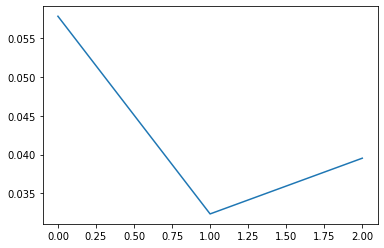

In [13]:
plt.plot(synapse.recent_activities)